In [1]:
import os
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import timm

c:\Users\phamh\miniconda3\envs\ml\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\phamh\miniconda3\envs\ml\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type

In [2]:
# Configuration
DATASET_DIR = "data"
CLASS_NAMES = ["Healthy", "Mosaic", "RedRot", "Rust", "Yellow"]
NUM_CLASSES = len(CLASS_NAMES)
INPUT_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
EPOCHS = 5
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
MODEL_NAME = "timm/convnextv2_tiny.fcmae"
SEED = 1729

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Custom Dataset Class
class SugarcaneDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load dataset
image_paths = []
labels = []

for i, class_name in enumerate(CLASS_NAMES):
    class_dir = Path(DATASET_DIR) / class_name
    class_images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.png"))
    
    image_paths.extend([str(img_path) for img_path in class_images])
    labels.extend([i] * len(class_images))

print(f"Total images found: {len(image_paths)}")

# Split dataset
train_idx, temp_idx = train_test_split(
    list(range(len(image_paths))), 
    test_size=0.3,
    stratify=labels,
    random_state=SEED
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[labels[i] for i in temp_idx],
    random_state=SEED
)

# Create datasets
train_dataset = SugarcaneDataset(
    [image_paths[i] for i in train_idx],
    [labels[i] for i in train_idx],
    transform=train_transform
)

val_dataset = SugarcaneDataset(
    [image_paths[i] for i in val_idx],
    [labels[i] for i in val_idx],
    transform=val_transform
)

test_dataset = SugarcaneDataset(
    [image_paths[i] for i in test_idx],
    [labels[i] for i in test_idx],
    transform=val_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total images found: 2521
Train set size: 1764
Validation set size: 378
Test set size: 379


In [6]:
# Create model
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=NUM_CLASSES
)

# Replace classifier with dropout
original_fc = model.head.fc
model.head.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(original_fc.in_features, NUM_CLASSES)
)

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience = 7
patience_counter = 0

c:\Users\phamh\miniconda3\envs\ml\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    print(f"Training on {len(dataloader)} batches...", flush=True)
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):  # Removed tqdm
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = probabilities.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}", flush=True)
    
    print(f"Training completed!", flush=True)
    return total_loss / len(dataloader), correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    print(f"Validating on {len(dataloader)} batches...", flush=True)
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):  # Removed tqdm
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = probabilities.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    print(f"Validation completed", flush=True)
    return total_loss / len(dataloader), correct / total

In [8]:
import sys
print('START TRAINING', flush=True)
sys.stdout.flush()

# Training loop
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}/{EPOCHS}', flush=True)
    sys.stdout.flush()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nRESULTS:', flush=True)
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}', flush=True)
    print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}', flush=True)
    sys.stdout.flush()
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered', flush=True)
            break

START TRAINING
EPOCH 1/5
Training on 56 batches...
Batch 10/56 - Loss: 1.1778
Batch 20/56 - Loss: 1.0764
Batch 30/56 - Loss: 0.8747
Batch 40/56 - Loss: 0.8326
Batch 50/56 - Loss: 0.5981
Training completed!
Validating on 12 batches...
Validation completed

RESULTS:
  Train Loss: 0.9627 | Train Acc: 0.6071
  Val Loss:   0.5315 | Val Acc:   0.7884
EPOCH 2/5
Training on 56 batches...
Batch 10/56 - Loss: 0.4571
Batch 20/56 - Loss: 0.6518
Batch 30/56 - Loss: 0.2902
Batch 40/56 - Loss: 0.2105
Batch 50/56 - Loss: 0.2902
Training completed!
Validating on 12 batches...
Validation completed

RESULTS:
  Train Loss: 0.4824 | Train Acc: 0.8107
  Val Loss:   0.4349 | Val Acc:   0.8492
EPOCH 3/5
Training on 56 batches...
Batch 10/56 - Loss: 0.3138
Batch 20/56 - Loss: 0.0774
Batch 30/56 - Loss: 0.4227
Batch 40/56 - Loss: 0.2738
Batch 50/56 - Loss: 0.2275
Training completed!
Validating on 12 batches...
Validation completed

RESULTS:
  Train Loss: 0.2437 | Train Acc: 0.9127
  Val Loss:   0.2683 | Val Acc

C:\Users\phamh\AppData\Local\Temp\ipykernel_29320\3380106979.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
Testing: 


Confidence Statistics:
Mean confidence: 0.9511 (95.11%)
Min confidence: 0.3660 (36.60%)
Max confidence: 0.9998 (99.98%)
Std confidence: 0.1122


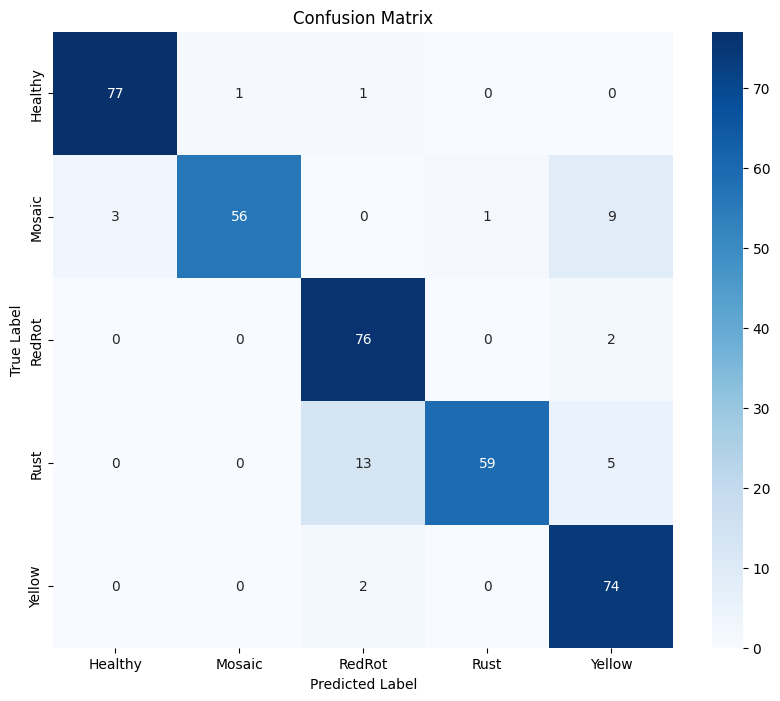

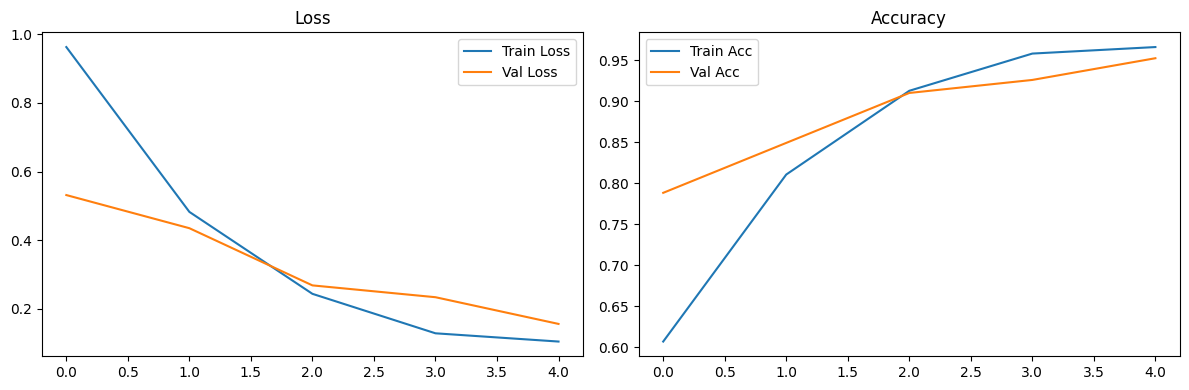

In [9]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Test function
def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_confidences = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            confidences, preds = probabilities.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    return total_loss / len(dataloader), all_preds, all_labels, all_confidences

# Run test
test_loss, test_preds, test_labels, test_confidences = test(model, test_loader, criterion, device)

# Print confidence statistics
test_confidences = np.array(test_confidences)
print(f'\nConfidence Statistics:')
print(f'Mean confidence: {test_confidences.mean():.4f} ({test_confidences.mean()*100:.2f}%)')
print(f'Min confidence: {test_confidences.min():.4f} ({test_confidences.min()*100:.2f}%)')
print(f'Max confidence: {test_confidences.max():.4f} ({test_confidences.max()*100:.2f}%)')
print(f'Std confidence: {test_confidences.std():.4f}')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
print(f"Number of epochs in history: {len(history['train_loss'])}")
print(f"History data: {history}")

Number of epochs in history: 5
History data: {'train_loss': [0.9627426456926125, 0.4824194874880569, 0.2436529264253165, 0.12864016921126417, 0.10460767787714888], 'train_acc': [0.6071428571428571, 0.8106575963718821, 0.9126984126984127, 0.9580498866213152, 0.9659863945578231], 'val_loss': [0.531458837290605, 0.4348892333606879, 0.2682616375386715, 0.233807144065698, 0.15598182985559106], 'val_acc': [0.7883597883597884, 0.8492063492063492, 0.91005291005291, 0.9259259259259259, 0.9523809523809523]}
